# Lesson L3 – Logistic Regression for Tweet Sentiment 📈❤️💔

Welcome to **Lesson L3** of our Colab‑ready DeepLearning.AI NLP beginner friendly remake!

## What you’ll learn
* Convert cleaned tweets into **numeric features**  
* Train a **Logistic Regression** classifier for sentiment  
* **Visualise** tweets in feature‑space and the model’s decision boundary  
* Evaluate accuracy & interpret the learned weights  
* Experiment live with an **interactive Gradio playground**

## Why this matters
Getting from *word counts* → *predictions* is the heart of many NLP systems.  
Logistic Regression is a surprisingly strong baseline and lays the groundwork for neural networks.

## Roadmap
1. **Setup & installs** – one cell, ready for Colab  
2. **Toy example** – six handmade tweets to see LR end‑to‑end  
3. **Real dataset** – 10 k NLTK tweets, build features on the fly  
4. **Visualisation** – scatter & decision boundary  
5. **Evaluation** – accuracy + confusion matrix  
6. **Gradio playground** – paste any text and get a sentiment score  

_👉 Let’s dive in!_


In [ ]:
# 🍀 Colab setup – run this first!
# Installs pinned to avoid version conflicts with Colab pre‑installs
import pandas as pd
!pip -q install --upgrade \
        "nltk" \
        "wordcloud" \
        "numpy>=1.26,<2.1" \
        "scikit-learn<1.7" \
        "gradio>=4.27.0" \
        "websockets>=13,<15" --progress-bar off

import nltk, ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except AttributeError:
    pass

for resource in ['stopwords', 'punkt', 'twitter_samples']:
    nltk.download(resource, quiet=True)

print("✅ Environment & NLTK corpora ready!")


✅ Environment & NLTK corpora ready!


## Let's build a classifier. First Toy, then real!

In this workbook, our goal is to build a system that can predict whether a Tweet is positive of negative. To keep things simple and interpretable, we won’t model word order or complex phrasing. Instead, we'll rely on how many positive and negative words appear in each Tweet.

In the end, each tweet will be reduced to a simple feature vector: just a count of how many positive and how many negative words it contains.

Ps. We will assign which words are positive or negative in the first place by using the 10k Tweet set that we've imported (which is already split into 5k positive and 5k negative).

## 1️⃣ Toy example – six mini‑tweets
We will take the 6 Tweets, clean them, and the build a mini logistic regression that decides if the Tweet is positive or negative.

Things to note: in the toy example we just define 3 positive words (pos_lex) and 3 negative words (neg_lex) to kick things off. In the full example we'll need to figure out which words are positive or negative in the first place.

We ALSO know which Tweets are positive and negative. So all we are doing is looking for some relationships between word sentiment counts and Tweet sentiment.

In [ ]:
#Clean and plot the 6 sentences
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def simple_process(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s]', '', sentence)
    return [stemmer.stem(w) for w in sentence.split() if w not in stop_words]

# Mini sentiment lexicon
pos_lex = {'love','great','happy'}
neg_lex = {'hate','bad','sad'}

def to_features(tokens):
    pos_cnt = sum(w in pos_lex for w in tokens)
    neg_cnt = sum(w in neg_lex for w in tokens)
    return [pos_cnt, neg_cnt]

#The 6 sentences are pre-defined as postive or negative (see np.array in next code snippet which has 1,1,1,0,0,0)
toy_tweets = [
    "I love this!",
    "This is great and makes me happy",
    "So happy, great vibes",
    "I hate this, really bad",
    "This is sad and bad",
    "I hate it so much"
]


For each sentence, we list how many positive and negative words are found.

In [ ]:
# Create DataFrame
data = {
    "Original Tweet": [],
    "Cleaned Tokens": [],
    "Features [pos_cnt, neg_cnt]": []
}

for tweet in toy_tweets:
    tokens = simple_process(tweet)
    features = to_features(tokens)
    data["Original Tweet"].append(tweet)
    data["Cleaned Tokens"].append(tokens)
    data["Features [pos_cnt, neg_cnt]"].append(features)

df = pd.DataFrame(data)

print(df.to_markdown(index=False))


| Original Tweet                   | Cleaned Tokens             | Features [pos_cnt, neg_cnt]   |
|:---------------------------------|:---------------------------|:------------------------------|
| I love this!                     | ['love']                   | [1, 0]                        |
| This is great and makes me happy | ['great', 'make', 'happi'] | [1, 0]                        |
| So happy, great vibes            | ['happi', 'great', 'vibe'] | [1, 0]                        |
| I hate this, really bad          | ['hate', 'realli', 'bad']  | [0, 2]                        |
| This is sad and bad              | ['sad', 'bad']             | [0, 2]                        |
| I hate it so much                | ['hate', 'much']           | [0, 1]                        |


So now we take that intermediate table we have built, and will train a logistic regression that is able to link the features (number of postive words, number of negative words) to whether the sentence is positive or negative.

How is this done? We call a scikit-learn package that uses an optimization algorithm to find the best parameters (weights and bias) that minimize a loss function — typically the log loss (a.k.a. binary cross-entropy) for the Logistic Regression Sigmoid function. We will cover it intuitively below, but feel free to go do a deep dive on the Sigmoid function (maybe compare it to the quadratic to build some intuition).

Just as an FYI: that optimization process where the best intercept and slope of the curve is found isdone via gradient descent, but we won't focus on the nuts and bolts of gradient descent here. Again, feel free to go do a deep dive, and note we will cover it later.

Somewhat advanced step: Lets build the Matrix Algebra data structures.

In [ ]:
# Define sentiment labels: 1 = positive, 0 = negative
y_toy = np.array([1, 1, 1, 0, 0, 0])

# Convert each tweet into a feature vector: [#positive_words, #negative_words]
X_toy = np.array([to_features(simple_process(t)) for t in toy_tweets])

# Display the resulting feature matrix
print(y_toy)
print("Toy feature matrix:\n", X_toy)


[1 1 1 0 0 0]
Toy feature matrix:
 [[1 0]
 [1 0]
 [1 0]
 [0 2]
 [0 2]
 [0 1]]


Above we list the Tweets by sentiment [1 1 1 0 0 0], and stack the positive and negative words per Tweets like this [1 0], where each "row" corresponds to the Tweets in order. Look at the above table to see how the 2 matrices match up to the Tweet sentiment and word sentiment.

## Now let's train the toy example using the Logistic Regression package
We are not actually hand implementing Gradient Descent here, but rather using a Python package.

For the quick and dirty intuition, it's like all we are doing is plotting the 6 Tweets on a graph with negative words on the Y Axis and positive words on the X axis and trying to find a line that best splits them into positive and negative.

You could manually eyeball this in the Toy Example by just placing the line. but in production grade large datasets you'll need an algorithmic way to accomplish this: Gradient Descent software packages.

In [ ]:
# Initialize and train a logistic regression classifier on the toy data
clf_toy = LogisticRegression()
clf_toy.fit(X_toy, y_toy)

# Print training accuracy (since this is a toy set, it should be 100%)
print("Toy accuracy:", clf_toy.score(X_toy, y_toy))


Toy accuracy: 1.0


The accuracy for our Toy Example is 100%. We were able to find a line that splits ALL Tweets correctly, with no outliers on the wrong side of the curve. Note this doesn't mean the "loss" is 0, it's just minimized. More on this below.

Let's visualize this. We plot the number of negative words in the Tweet on the Y axis and the number of positive words on the X axis.

BEFORE YOU PROCEED, go back to the summary table above. Visualize where the various Tweets will be plotted on this simple XY graph before you proceed. If you can visualize it (or write it down - it's just 6 points), draw a line that you think best splits the Tweets down the middle. You just hacked together an ML optimization :)

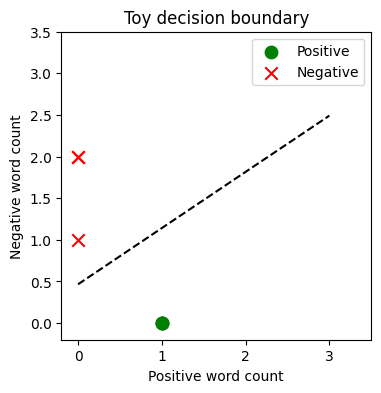

In [ ]:
# ---------- Visualization ----------
# Create a new 4x4 inch plot
plt.figure(figsize=(4,4))

# Plot the data points with different markers for positive and negative labels
for label, marker, color in [(1, 'o', 'green'), (0, 'x', 'red')]:
    mask = y_toy == label
    plt.scatter(
        X_toy[mask, 0], X_toy[mask, 1],
        marker=marker, color=color,
        label='Positive' if label else 'Negative', s=80
    )

# Extract the learned weights and intercept from the trained model
coef = clf_toy.coef_[0]       # [w1, w2]
intercept = clf_toy.intercept_[0]  # bias term

# Generate x-values to plot the decision boundary line
xs = np.linspace(0, 3, 100)

# Compute corresponding y-values for the decision boundary: w1*x + w2*y + b = 0
ys = -(coef[0]*xs + intercept) / coef[1]

# Plot the decision boundary as a dashed black line
plt.plot(xs, ys, '--k')

# Label the axes
plt.xlabel('Positive word count')
plt.ylabel('Negative word count')

# Set visible limits for clarity
plt.xlim(-0.2, 3.5)
plt.ylim(-0.2, 3.5)

# Add a legend and title
plt.legend()
plt.title("Toy decision boundary")

# Show the final plot
plt.show()


Did you correctly visualize the plotted Tweets and the curve. 3 Greens on top of each other with [1,0], and the Red split up: 1 at [0,1] and 2 at [0,2]. Think about different lines that might also split these Tweets with 100% accuracy. Why does the line sit where it does? If you want to dive deeper, go ask ChatGPT what an ideal loss maximization curve is for a logistic regression function and have fun deep diving.

And there you have it, using the built-in Gradient Descent function in the Python package, we have arrived at a line that splits positive vs negative tweets based on the number of positive vs negative words.

We could now take any Tweet and feed it to the system, getting back it's best prediction about whether the Tweet is positive or negative (or course it would have to contain some of our 6 words for this to work). At this end of this workbook you'll build a little Gradio app with a UI to allow you to do this using the model we'll train below.

## Sidebar: How does the Logistic Regression Function really work?
Now let's actually look at how the "decision function" really works and is shaped. For ease we'll simply feed in the difference between negative and positive words per Tweet to see how this gets "processed" by the underlying function.

Run the below code, then take time to understand what the curve is doing. In some non-linear way, as the number of positive words relative to negative words increases (moving rightword on the X axis) the probability that the Tweet is positive goes up.

Super straightforward. We came to the exercise already using the Logistic Regression function, so the only thing we've really trained is the slope and intercept of that curve — that is, how steeply it rises, and where it flips from predicting mostly "negative" to mostly "positive."

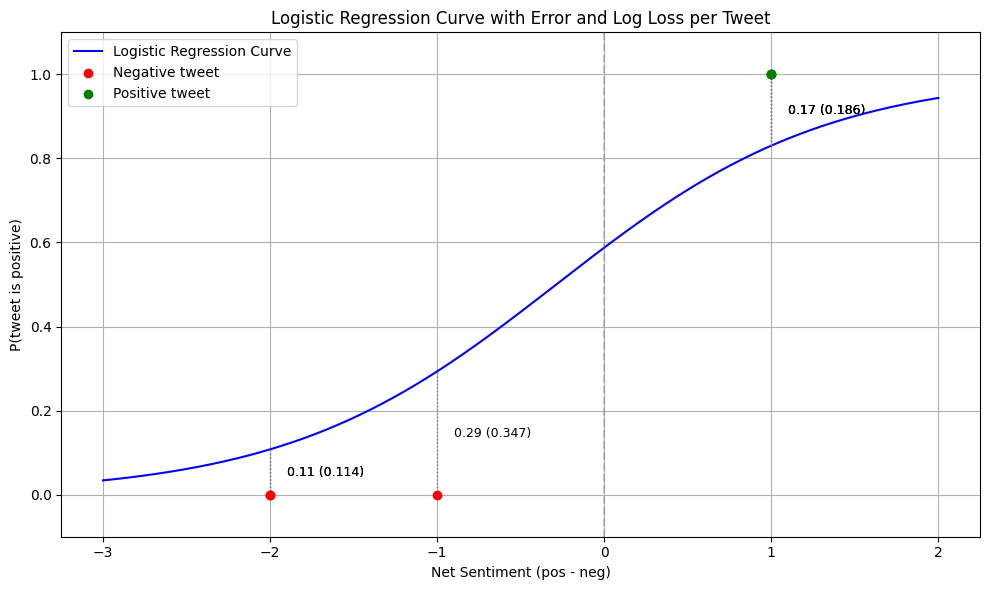

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Compute net sentiment feature: pos - neg
net_sentiment = X_toy[:, 0] - X_toy[:, 1]
X_1d = net_sentiment.reshape(-1, 1)

# Fit logistic regression
clf_1d = LogisticRegression()
clf_1d.fit(X_1d, y_toy)

# Get weight and bias
w = clf_1d.coef_[0][0]
b = clf_1d.intercept_[0]

# Smooth sigmoid curve
x_vals = np.linspace(net_sentiment.min() - 1, net_sentiment.max() + 1, 300)
z = w * x_vals + b
probs = 1 / (1 + np.exp(-z))

# Predict for actual points
z_points = w * net_sentiment + b
probs_points = 1 / (1 + np.exp(-z_points))

# Compute per-point log loss
log_losses = - (y_toy * np.log(probs_points) + (1 - y_toy) * np.log(1 - probs_points))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, probs, label='Logistic Regression Curve', color='blue')
plt.axvline(x=0, linestyle='--', color='gray', alpha=0.4)

# Show vertical lines + error and loss labels
for xi, yi, pi, loss in zip(net_sentiment, y_toy, probs_points, log_losses):
    error = abs(yi - pi)
    label = f"{error:.2f} ({loss:.3f})"
    plt.plot([xi, xi], [yi, pi], color='gray', linestyle=':', linewidth=1)
    plt.text(xi + 0.1, (yi + pi) / 2, label, fontsize=9, color='black', ha='left', va='center')

# Plot actual data points
plt.scatter(net_sentiment[y_toy == 0], y_toy[y_toy == 0], c='red', label='Negative tweet', zorder=3)
plt.scatter(net_sentiment[y_toy == 1], y_toy[y_toy == 1], c='green', label='Positive tweet', zorder=3)

# Labels and layout
plt.xlabel("Net Sentiment (pos - neg)")
plt.ylabel("P(tweet is positive)")
plt.title("Logistic Regression Curve with Error and Log Loss per Tweet")
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()


And now, before moving on to the real Twitter example, here is a key and replicable lesson across ML. No matter the function (1D sigmoid curve above, 2D decision plane we plotted above that, or a deep neural net), machine learning boils down to one core principle:
minimize a loss function that measures how far your model is from getting each training example right.

In the above example I include the distance and loss (log loss function for Sigmoid) for each data point just to show the non-linearity of the loss. You could go calculate this for the linear decision graph above and find the same value.

##  2️⃣ Now let's replicate the toy exercise on real Twitter Data

Now we'll surface the sentiment feature words directly from the data, then use them to train the model.

First let's rebuild the helper functions – inline (no utils.py like in the DeepLearning course. We'll build the code in the Colab environment). We did this already in previous weeks but try to follow the code under each function.

In [ ]:
import re, numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_tweet(tweet: str):
    tweet = tweet.lower()
    tweet = re.sub(r'https?://\S+', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return [stemmer.stem(w) for w in tweet.split() if w not in stop_words]

def build_freqs(tweets, ys):
    freqs = {}
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

def tweet_to_xy(tweet, pos_vocab, neg_vocab):
    tokens = process_tweet(tweet)
    pos_cnt = sum(tok in pos_vocab for tok in tokens)
    neg_cnt = sum(tok in neg_vocab for tok in tokens)
    return np.array([pos_cnt, neg_cnt])


## 3️⃣ Full tweet corpus – build features & train

We will now run the cleaned Tweets through a counter to get the frequency that words appear. By getting counts for positive and negative words we can then use these in our classifier down the road. Note, some words are listed as both positive and negative.

We build two sets:

pos_vocab: words that appear more than 5 times in positive tweets

neg_vocab: words that appear more than 5 times in negative tweets

In [ ]:
from nltk.corpus import twitter_samples
import numpy as np

pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')
tweets = pos_tweets + neg_tweets
ys = np.append(np.ones(len(pos_tweets)), np.zeros(len(neg_tweets)))

freqs = build_freqs(tweets, ys)

# Vocab threshold
pos_vocab = {w for (w,y) in freqs if y==1 and freqs[(w,1)] > 5}
neg_vocab = {w for (w,y) in freqs if y==0 and freqs[(w,0)] > 5}

print(f"Positive vocab: {len(pos_vocab)} words | Negative vocab: {len(neg_vocab)} words")

X = np.array([tweet_to_xy(t, pos_vocab, neg_vocab) for t in tweets])
print("Feature matrix shape:", X.shape)


Positive vocab: 780 words | Negative vocab: 796 words
Feature matrix shape: (10000, 2)


Let's print the top 5 positive, negative, and dual-purpose (pos and neg) words.

In [ ]:
# Separate word counts
from collections import defaultdict

# Step 1: Build separate dicts for pos and neg counts
pos_counts = defaultdict(int)
neg_counts = defaultdict(int)

for (word, label), count in freqs.items():
    if label == 1:
        pos_counts[word] += count
    else:
        neg_counts[word] += count

# Step 2: Get top 5 positive words
top_pos = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Step 3: Get top 5 negative words
top_neg = sorted(neg_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Step 4: Get top 5 shared words (appear in both pos and neg, ranked by total freq)
shared_words = set(pos_counts) & set(neg_counts)
shared_freqs = [(w, pos_counts[w] + neg_counts[w]) for w in shared_words]
top_shared = sorted(shared_freqs, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Print everything
print("🔵 Top 5 Positive Words:")
for w, c in top_pos:
    print(f"{w:<15} {c}")

print("\n🔴 Top 5 Negative Words:")
for w, c in top_neg:
    print(f"{w:<15} {c}")

print("\n🟣 Top 5 Shared Words (in both pos and neg):")
for w, c in top_shared:
    print(f"{w:<15} {c} (pos: {pos_counts[w]}, neg: {neg_counts[w]})")


🔵 Top 5 Positive Words:
thank           642
follow          447
love            399
day             243
u               241

🔴 Top 5 Negative Words:
im              475
miss            300
pleas           273
follow          263
want            246

🟣 Top 5 Shared Words (in both pos and neg):
thank           749 (pos: 642, neg: 107)
im              716 (pos: 241, neg: 475)
follow          710 (pos: 447, neg: 263)
love            551 (pos: 399, neg: 152)
like            452 (pos: 231, neg: 221)


### Train / test split & model performance

Now we will train logistic regression. All this means is we'll use vocabulary-based features you built earlier (list of positive and negative words).

In principle, the logistic regression used here is exactly the same as in your toy example. The core algorithm is identical. What changes is the scale and the input representation.



Difference between the toy example and this real example

| Aspect                | Toy Example                    | Twitter Dataset Example                                  |
| --------------------- | ------------------------------ | -------------------------------------------------------- |
| **Features**          | 2D → `[pos_count, neg_count]`  |  2D → `[pos_count, neg_count]` |
| **Data size**         | 6 sentences                    | 10,000 tweets                                            |
| **Vocabulary source** | Manually defined small lexicon | Auto-generated from word frequencies                     |
| **Separability**      | Fully separable in 2D          | Likely not linearly separable in high-dimensional space  |
| **Visualization**     | Easy to plot (2D space)        | Easy to plot (2D space, just many data points)                       |

In [ ]:
#import the ML packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#split the 10k Tweets into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.2, random_state=42, stratify=ys)

#Setup the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Now plot the outcome

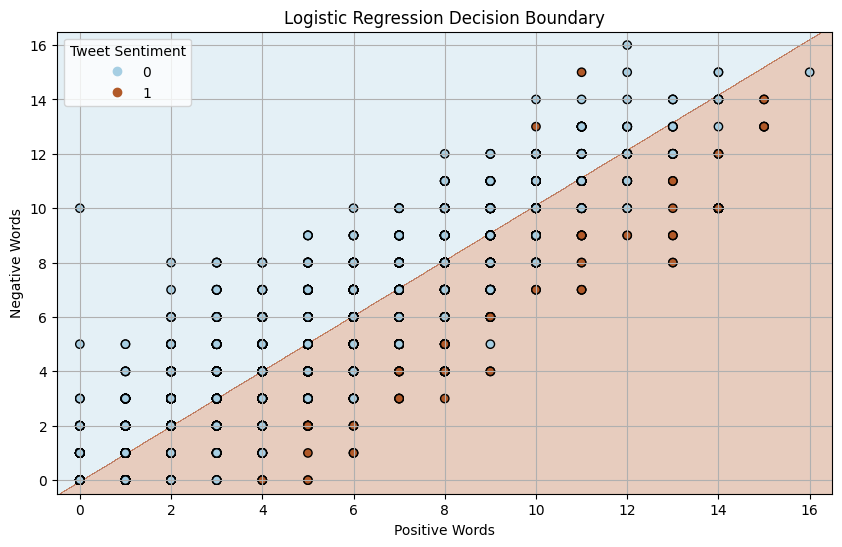

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a mesh grid over feature space
h = 0.01  # grid step
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

# Plot the original data points
scatter = plt.scatter(X[:, 0], X[:, 1], c=ys, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel("Positive Words")
plt.ylabel("Negative Words")
plt.title("Logistic Regression Decision Boundary")
plt.legend(*scatter.legend_elements(), title="Tweet Sentiment")
plt.grid(True)
plt.show()


How did we do? Just eyeballing it, you can see many Tweets "on the wrong side of the curve." Also, many tweets contain *no* positive words (x=0) or negative words (y=0); that’s why points hug the axes.

Looks like our line isn't doing a great job of segmenting the content. Think about another curve that might fit better? Or perhaps additional information about each Tweet that could help.


Now let's get back some of the actual metrics from the ML package we ran to understand better how we did.

Train accuracy: 0.662125
Test  accuracy: 0.6615


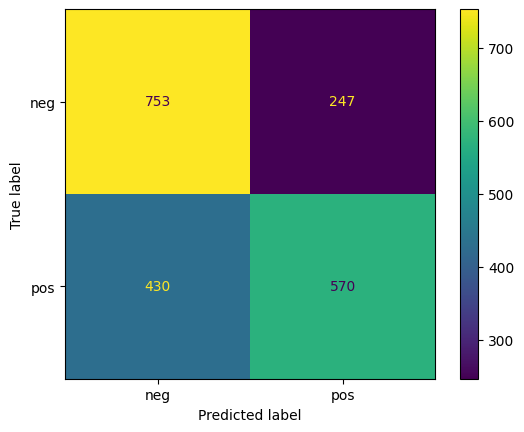

In [ ]:
print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test  accuracy:", accuracy_score(y_test,  model.predict(X_test)))


✅ Train accuracy: 0.662125
This means the model correctly predicted about 66.2% of the training data — it learned enough patterns to get 66% of its predictions right on the data it was trained on.

✅ Test accuracy: 0.6615
This is the accuracy on unseen test data, and it's 66.15%, very close to the training accuracy.

The closeness of train and test accuracy (66.2% vs 66.15%) suggests that:

The model is not overfitting (it generalizes well from training to test data).

It may not be very powerful — it learned, but not beyond basic patterns.

### Visualising tweet distribution & decision boundary

Now lets create a "confusion matrix". This is a confusion matrix plot that shows how your logistic regression model performed on the test set for Tweet sentiment classification. It will have values something like this.

|                    | **Predicted: Negative**          | **Predicted: Positive**          |
| ------------------ | -------------------------------- | -------------------------------- |
| **True: Negative** | **753** = ✅ True Negatives (TN)  | **247** = ❌ False Positives (FP) |
| **True: Positive** | **430** = ❌ False Negatives (FN) | **570** = ✅ True Positives (TP)  |


In [ ]:

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['neg','pos'])

## 4️⃣ Interactive Gradio sentiment tester

Now we'll build a fun little UI app that takes the model WE JUST TRAINED and let's you do a sentiment analysis of any sentence.

In [ ]:
import gradio as gr
from collections import Counter

def predict_sentiment(text):
    feats = tweet_to_xy(text, pos_vocab, neg_vocab)
    prob_pos = float(model.predict_proba([feats])[0][1])
    label = "Positive 😊" if prob_pos >= 0.5 else "Negative 😞"
    return {
        "Positive-count": int(feats[0]),
        "Negative-count": int(feats[1]),
        "Prob‑positive": round(prob_pos, 3),
        "Prediction": label
    }

with gr.Blocks() as demo:
    gr.Markdown("### 🎛️ Sentiment tester (Logistic Regression)")
    txt = gr.Textbox(label="Enter tweet text", lines=3)
    out = gr.JSON(label="Model output")
    txt.submit(predict_sentiment, txt, out)
    gr.Button("Run").click(predict_sentiment, txt, out)

# Uncomment the next line when running in Colab
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://045f37645f76df596a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
